In [1]:
import tensorflow as tf
from tensorflow.keras import layers

print(tf.__version__)


2.12.0


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
import numpy as np
X_val = np.load('gdrive/My Drive/UPJV/missing/X_val.npy')
y_val = np.load('gdrive/My Drive/UPJV/missing/y_val.npy')
X_test = np.load('gdrive/My Drive/UPJV/missing/X_test.npy')
y_test = np.load('gdrive/My Drive/UPJV/missing/y_test.npy')


In [4]:
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)


(15921, 303)
(15921, 303)
(15920, 303)
(15920, 303)


In [5]:
noisy_point_clouds = np.concatenate((X_val, X_test), axis=0)
noisy_point_clouds = noisy_point_clouds.reshape(-1, 101, 3)
noisy_point_clouds.shape

(31841, 101, 3)

In [6]:
clean_point_clouds = np.concatenate((y_val, y_test), axis=0)
clean_point_clouds = clean_point_clouds.reshape(-1, 101, 3)
clean_point_clouds.shape

(31841, 101, 3)

In [7]:
from sklearn.model_selection import train_test_split

# Assuming your original dataset is noisy_point_clouds and clean_point_clouds

noisy_train, noisy_test, clean_train, clean_test = train_test_split(noisy_point_clouds, clean_point_clouds, test_size=0.2, random_state=42)

# Now, noisy_train and clean_train are your training dataset.
# And, noisy_test and clean_test are your test dataset.


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten

num_points = 101
dims = 3

input_point_cloud = Input(shape=(num_points, dims))

# Pass each point independently through the MLP.
x = Dense(64, activation='relu')(input_point_cloud)
x = Dense(32, activation='relu')(x)
x = Dense(3)(x)  # The output size should match the number of point cloud dimensions.

mlp = Model(input_point_cloud, x)

mlp.compile(optimizer='adam', loss='mean_squared_error')

history = mlp.fit(noisy_point_clouds, clean_point_clouds,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_split=0.2)



Epoch 1/100
100/100 [==============================] - 7s 7ms/step - loss: 0.0316 - val_loss: 0.0077
Epoch 2/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0075 - val_loss: 0.0074
Epoch 3/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 4/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0073 - val_loss: 0.0073
Epoch 5/100
100/100 [==============================] - 1s 5ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 6/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0073 - val_loss: 0.0072
Epoch 7/100
100/100 [==============================] - 1s 6ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 9/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 10/100
100/100 [==============================] - 1s 8ms/step - loss: 0.0072 - val_lo

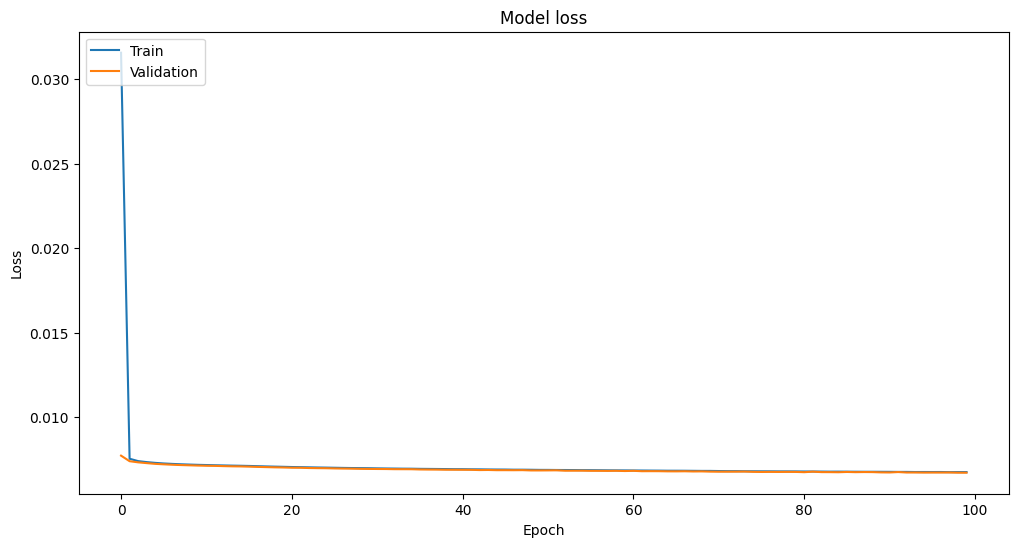

In [9]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [10]:
# evaluate model
test_loss = mlp.evaluate(noisy_test, clean_test, verbose=0)

print(f'Test Loss: {test_loss}')

Test Loss: 0.0067604403011500835


In [11]:
# make predictions for test data
predictions = mlp.predict(noisy_test)

# select a random example from the test set
import numpy as np
i = np.random.choice(len(noisy_test))

# print the predicted and true values
#print('Predicted:', predictions[i])
#print('True:', clean_test[i])


200/200 [==============================] - 1s 2ms/step


In [12]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot_point_cloud(point_cloud):
    """
    Plots a 3D point cloud using matplotlib.

    Args:
    point_cloud: np.ndarray of shape (N, 3)
    """

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    xs = point_cloud[:, 0]
    ys = point_cloud[:, 1]
    zs = point_cloud[:, 2]

    ax.scatter(xs, ys, zs)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.show()


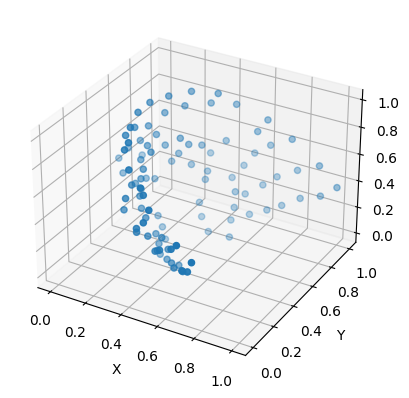

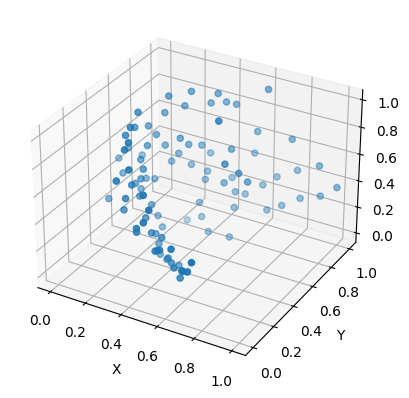

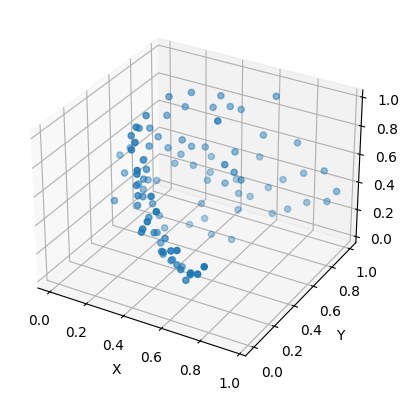

In [13]:
%matplotlib inline

# Display a clean point cloud
plot_point_cloud(clean_test[i])

# Display its corresponding noisy point cloud
plot_point_cloud(noisy_test[i])

# Display the denoised point cloud
plot_point_cloud(predictions[i])


In [14]:
import json
import pandas as pd

# convert the history.history dict to a pandas DataFrame:
hist_df = pd.DataFrame(history.history)

# or save to csv:
hist_csv_file = 'gdrive/My Drive/UPJV/missing/history_mlp-0.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)